<h1> Recommendation Engine</h1>

A plan for a company to increase its market share globally, with a Recommendation engine that recommends products to customers based on their past purchase habits, can be vital to achieving its objective.

The recommender will focus on increasing each customer's market basket value by suggesting products based on their past purchase behaviour.

In [241]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

In [243]:
#load the dataset using pandas package
df = pd.read_csv('Online_retail.zip')

In [245]:
# Prints the first five rows of the dataset
df.head()

,ProductKey,CustomerKey,SalesOrderNumber,ProductName,OrderQuantity,Price,OrderDate,Unnamed: 7
0,310,21768,SO43697,"Road-150 Red, 62",1,3578.2700,29/12/2010,NaN
1,346,28389,SO43698,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,NaN
2,346,25863,SO43699,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,NaN
3,336,14501,SO43700,"Road-650 Black, 62",1,699.0982,29/12/2010,NaN
4,346,11003,SO43701,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,NaN


In [247]:
# Let's exclude the 'Unnamed:7' column from our dataframe
df = df.loc[:, df.columns!='Unnamed: 7']
df.head()

,ProductKey,CustomerKey,SalesOrderNumber,ProductName,OrderQuantity,Price,OrderDate
0,310,21768,SO43697,"Road-150 Red, 62",1,3578.2700,29/12/2010
1,346,28389,SO43698,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010
2,346,25863,SO43699,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010
3,336,14501,SO43700,"Road-650 Black, 62",1,699.0982,29/12/2010
4,346,11003,SO43701,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010


In [249]:
# Let's check the dimention of the dataset
df.shape

(60398, 7)

<h3>Basic Data Analysis</h3>

Let's get familiar with the dataset. To gain some impressions, will try getting some counts for different columns.

In [254]:
num_uniq_dates =df['OrderDate'].nunique()
print("The number of unique dates is: ", num_uniq_dates)

The number of unique dates is:  1124


In [256]:
df.describe()

,ProductKey,CustomerKey,OrderQuantity,Price
count,60398.000000,60398.000000,60398.0,60398.000000
mean,437.557932,18841.685420,1.0,486.086911
std,118.088390,5432.430404,0.0,928.489892
min,214.000000,11000.000000,1.0,2.290000
25%,359.000000,14003.000000,1.0,7.950000
50%,479.000000,18143.000000,1.0,29.990000
75%,529.000000,23429.750000,1.0,539.990000
max,606.000000,29483.000000,1.0,3578.270000


<h3>Lookup table</h3>
Lookup table that keeps track of each items ID along with a desciption of that item.

In [123]:
# Only get unique item/description pair
lookUp = df[['ProductKey', 'ProductName']].drop_duplicates()

In [125]:
lookUp.head()

,ProductKey,ProductName
0,310,"Road-150 Red, 62"
1,346,"Mountain-100 Silver, 44"
3,336,"Road-650 Black, 62"
5,311,"Road-150 Red, 44"
7,351,"Mountain-100 Black, 48"


In [127]:
lookUp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 7276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductKey   158 non-null    int64 
 1   ProductName  158 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProductKey        60398 non-null  int64  
 1   CustomerKey       60398 non-null  int64  
 2   SalesOrderNumber  60398 non-null  object 
 3   ProductName       60398 non-null  object 
 4   OrderQuantity     60398 non-null  int64  
 5   Price             60398 non-null  float64
 6   OrderDate         60398 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 3.2+ MB


***Let's visualise some statistics of the data.***

We will visualise the days/months where the most and least transactions happened. 

In [132]:
df['Days'] = pd.to_datetime(df['OrderDate']).dt.day_name()
df.head()

,ProductKey,CustomerKey,SalesOrderNumber,ProductName,OrderQuantity,Price,OrderDate,Days
0,310,21768,SO43697,"Road-150 Red, 62",1,3578.2700,29/12/2010,Wednesday
1,346,28389,SO43698,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday
2,346,25863,SO43699,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday
3,336,14501,SO43700,"Road-650 Black, 62",1,699.0982,29/12/2010,Wednesday
4,346,11003,SO43701,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday


In [136]:
# Let's see the value counts of the daily sales in ascending order
daily_sales = df['Days'].value_counts().sort_values(ascending=True)

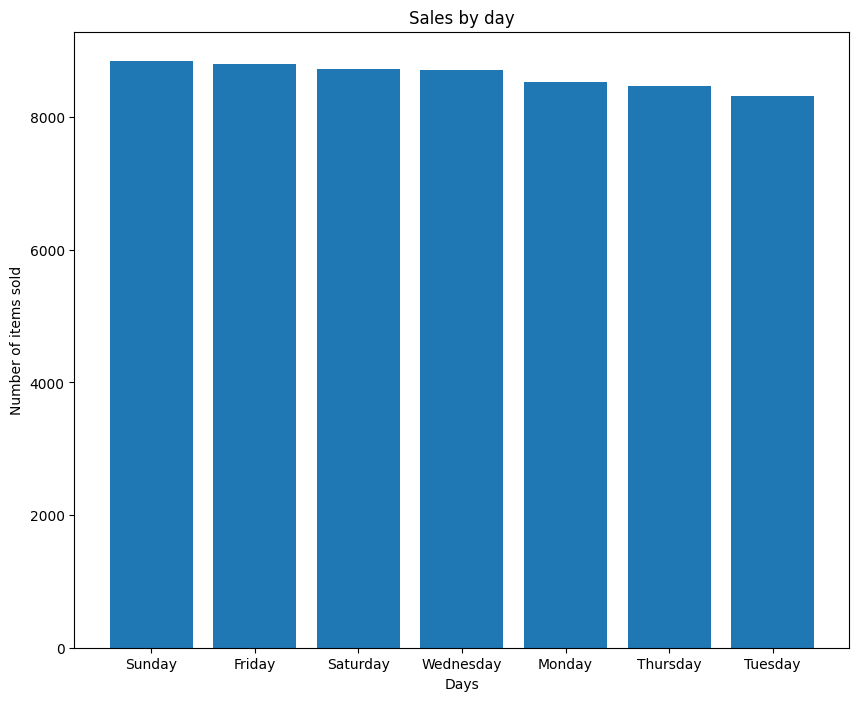

In [138]:
plt.figure(figsize=(10,8))
plt.bar(daily_sales.index, daily_sales.sort_values(ascending=False).values,label="Daily sales")
plt.title("Sales by day")
plt.xlabel("Days")
plt.ylabel("Number of items sold")
plt.show()

- The graph shows seven days sales in which Friday and weekend have the highest sales.

In [141]:
df['Months'] = pd.to_datetime(df['OrderDate']).dt.month_name()
df.head()

,ProductKey,CustomerKey,SalesOrderNumber,ProductName,OrderQuantity,Price,OrderDate,Days,Months
0,310,21768,SO43697,"Road-150 Red, 62",1,3578.2700,29/12/2010,Wednesday,December
1,346,28389,SO43698,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday,December
2,346,25863,SO43699,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday,December
3,336,14501,SO43700,"Road-650 Black, 62",1,699.0982,29/12/2010,Wednesday,December
4,346,11003,SO43701,"Mountain-100 Silver, 44",1,3399.9900,29/12/2010,Wednesday,December


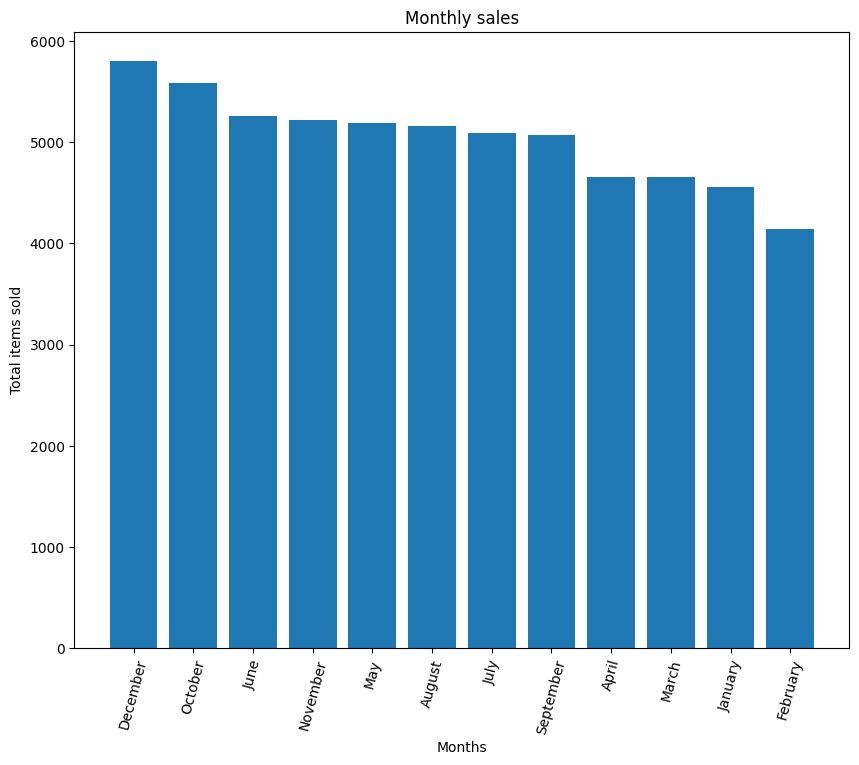

In [143]:
monthly_sales = df['Months'].value_counts()

plt.figure(figsize=(10,8))
plt.bar(monthly_sales.index, monthly_sales.sort_values(ascending=False).values)
plt.title('Monthly sales')
plt.xlabel('Months')
plt.ylabel('Total items sold')
plt.xticks(rotation=75)
plt.show()

- We can see the sales of the 12 months in which spring and summer sales are higher although, December and the October have the highest sales because they are the festive period. 

- Let's group the purchase quantities together by ProductKey and CustomerKey.
- Let's change any sums that equals to zero to one (as this can happen if items were returned, hence, we want to indicate that a customer actually purchased the items instead of assuming no interaction between the customer and item ever took place).
- Only include customers with positive purchase total to eliminate possible errors.

In [167]:
df1 = df[['ProductKey','OrderQuantity','CustomerKey']]
groupCP = df1.groupby(['CustomerKey','ProductKey']).sum().reset_index()
groupCP.OrderQuantity.loc[groupCP.OrderQuantity == 0] = 1 # Replace the sum of zero with one indicating the purchase took place 
gcp = groupCP.query('OrderQuantity > 0') # Only get customers purchase were totals are positive.

In [169]:
gcp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59051 entries, 0 to 59050
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerKey    59051 non-null  int64
 1   ProductKey     59051 non-null  int64
 2   OrderQuantity  59051 non-null  int64
dtypes: int64(3)
memory usage: 1.8 MB


In [171]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ProductKey     60398 non-null  int64
 1   OrderQuantity  60398 non-null  int64
 2   CustomerKey    60398 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [173]:
gcp.head()

,CustomerKey,ProductKey,OrderQuantity
0,11000,214,1
1,11000,344,1
2,11000,353,1
3,11000,485,1
4,11000,488,1


<h3>Set up our sparse ratings matrix</h3>

To save a lot of memory by keeping the matrix sparse and only saving the locations and values of products that are not zero.

In [176]:
# Creating a sparse ratings matrix of users and items.
customers = list(np.sort(gcp.CustomerKey.unique())) # Get our unique customers
products = list(np.sort(gcp.ProductKey.unique())) # Get our unique products
quantity = list(gcp.OrderQuantity) # list of the order quantity

rows = gcp.CustomerKey.astype('category').cat.codes # get the assocated row index
cols = gcp.ProductKey.astype('category').cat.codes # get the associated column index

purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))
purchases_sparse # let's check our final matrix object

<18484x158 sparse matrix of type '<class 'numpy.int32'>'
	with 59051 stored elements in Compressed Sparse Row format>

- This shows we have 18,484 customers, 158 products and sold(purchased) 59051.

In [179]:
matrix_size = purchases_sparse.shape[0] * purchases_sparse.shape[1] #Number of interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity

97.97803231806365

- We can see that 98% of the interaction matrix is sparse. For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. We are below this, so we should be able to get decent results.

<h3>Creating a Training and Validation Set</h3>

In [184]:
import random

def make_train(ratings, pct_test = 0.2): 
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings
    where a user-item interaction has been used as a test set. The test set will contain all the original
    ratings, while the training set replaces the specified percentage with zero in the original ratings matrix.

    Parameters:

    ratings - is the original ratings matrix from which we want to generate a train/test set. 
    The test is just a complete copy of the original set, which is in the form of a sparse csr_matrix.

    pct_test - The percentage of user-item interactions where an interaction took place that we want to mask
    in the training set for later comparison to the test, which contains all  the original ratings.

    return:

    training_set - The altered version of the original data with a certain percentage of the user-item pair
    that originally had interaction set back to zero.

    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order compares
    with the actual interactions.

    user_inds - From the randomly selected user_item indices, which user rows were altered in the training data. 
    This will be necessary later when evaluating the performance via AUC.
    
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set.
    test_set[test_set != 0] = 1 # store the test set as a binary performance matrix
    training_set = ratings.copy() # Make a copy of the original dataset, which we can alter as our training set.
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings dataset where an interaction exists.
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user, items index into list
    random.seed(20) # Set the random seed for reproducibility
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement.
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # output the unique list of user rows that were altered

In [186]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

<h3>Implementing ALS for Implicit Feedback</h3>

In [189]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    Implicit weighted ALS taken from HU, Koren, and Volinsky 2008. Designed for alternating least squares and implicit
    feedback based collaborative filtering.

    parameters:

    training_set - our matrix of ratings with shape m x n, where m is the number of users and n is the number of itens.
    should be a sparse csr matrix to save space.

    lambda_val - used for regularisation during alternating least squares. Increasing this value may increase bais but 
    decrease variance. default is 0.1.

    alpha - The parameter is assocaited with the confidnece matrix discussed in the paper, where Cui = 1 + alpha * Rui.
    The paper found a fault of 40 most effective. Decreasing this will decrease the variability in confidence between various
    ratings.

    iterations - The number of items to iterate between both the user feature vector and item feature vector in alternating
    least squares. More iteration will allow better convergence at the cost of increased computation.
    The author found 10 iterations was sufficient, but more may be required to converge.

    rank_size - The number of latent feature in the user/item feature vector. The paper recommends varying this between
    20-2000. increasing the number of features may overfit but could reduce bias.

    seed - Set the seed for reproducible results.

    returns:

    The feature vectors for users and items. The dot product of these feature vectors should give you the expected "rating"
    at each point in our original matrix.
    '''
    # First set of confidence matrix
    conf = (alpha * training_set) # To allow matrix to stay sparse, I'll add one later when each row is taken and converted to dense

    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n

    # Initailise our x/y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)

    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x x n but we can
    # transpose at the end. Makes calculation more simple

    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularisation term lambda*I

    # We can compute this before iteration
    # Begin iterations
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at the beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, don't need to subtract 1 since we never added it
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in Cu-I+I=Cu

            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu)
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper
        # Begin iteration to solve for Y based on fixed X
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense.
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci-I term, don't need to subtract 1 since we never added it
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
        # End iterations
        return X, Y.T
# Transpose at the end to make up for not being transposed at the beginning.
# Y needs to be rank x n. Keep these as separate matrices for scale reasons.


In [191]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15,
                                             iterations = 1, rank_size = 20)                                    

In [193]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:5]

array([ 0.02578946, -0.01339369, -0.01591212, -0.00499155, -0.00279749])

<h3>Speeding up ALS</h3>

In [196]:
import implicit

In [198]:
from implicit.als import AlternatingLeastSquares
alpha = 40
item_user_data = (product_train * alpha).astype('double')
model = AlternatingLeastSquares(factors = 20, regularization = 0.1, iterations = 20)

model.fit(item_user_data)
user_vecs = model.user_factors
item_vecs = model.item_factors

  0%|          | 0/20 [00:00<?, ?it/s]

<h3>Evaluating the Recommender System</h3>

The training set has 20% of the purchases masked. This will allow us to evaluate the performance of our recommender system. Essentially, we need to see if the order of recommendations for each user matches the items they purchased. A commonly used metric for this problem is the area under the Receiver Operating Characteristic (or ROC) curve. A greater area under the curve means we are recommending items that end up being purchased near the top of the list of recommended items.

In [202]:
from sklearn import metrics

def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using Sklearn's metrics.

    parameters:

    - predictions: your prediction output.
    
    - test: the actual target result you are comparing to.

    returns:

    - AUC (area under the Receiver Operating Characteristic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [204]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    ''' 
    Now, utilise this helper function inside a second function that will calculate the AUC for each user in our
    training set with at least one item masked. It should also calculate the AUC for the most popular items to compare.
    
    '''
    store_auc = [] # an empty list to store the AUC for each user that had an item removed from the training set.
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item interactions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero.
        # Select all ratings from the MF prediction for this user that originally had no iteration
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1)
        # Select the binarised yes/no interaction pairs from the original full data
        # That aligh with the same pairs in training.
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items.
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store.
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

Return the mean AUC rounded to three decimal places for both test and popularity benchmark.
We can now use this function to see how our recommender system is doing. To use this function, we will need to transform
our output from the ALS function to csr_matrix format and transpose the item vectors. The original pure Python version
output the user and item vectors into the correct format already.

In [207]:
store_auc, popularity_auc = calc_mean_auc(product_train, product_users_altered,
                                          [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)],
                                          product_test)

# AUC for our recommender system
print(store_auc)
print(popularity_auc)

0.757
0.831


Trying out the code

In [210]:
customers_arr = np.array(customers) # Array of customer IDs from the ratings matrix
products_arr = np.array(products) # Array of product IDs from the ratings matrix

<h3>Function that returns a list of the productnames from our earlier created lookup table.</h3>

Now, we can create a function that will return a list of the item descriptions from our earlier created item lookup table.

In [216]:
def get_items_purchased(CustomerKey, mf_train, customer_list, product_list, lookUp):
    '''
    This function will return a list of the item description/names to our users.

    parameters:

    CustomerKey - the customerkey 

    mf_train - the training matrix you used for matrix factoorisation fitting

    customer_list - an array of customer's ID numbers that make up the rows of your ratings matrix (in order of matrix)

    product_list - an array of product's numbers that make up the rows of your ratings matrix (in order of matrix)

    lookUp - a simple pandas dataframe of the unique product ID/product descriptions available
    '''

    cust_ind = np.where(customer_list == CustomerKey)[0][0] # Retunrs the index row of our customer id
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] # Get column indices of purchased items
    prod_codes = product_list[purchased_ind] # Get the stock codes for our purchased items
    return lookUp.loc[lookUp.ProductKey.isin(prod_codes)]

In [218]:
# We need to look these up by a customer's ID. Looking at the list of customers:
customers_arr[:5]

array([11000, 11001, 11002, 11003, 11004], dtype=int64)

In [220]:
get_items_purchased(11000, product_train,customers_arr, products_arr, lookUp)

,ProductKey,ProductName
8,344,"Mountain-100 Silver, 38"
5442,214,"Sport-100 Helmet, Red"
5459,573,"Touring-1000 Blue, 46"
5476,485,Fender Set - Mountain
5535,488,"Short-Sleeve Classic Jersey, S"


We can see that the customer purchased those products. What products does the recommender system say this customer should purchase?

We need to create another function that does this. Let's also import the MinMaxScaler from scikit-learn to help with this.

<h3>Function that recommend products to customers.</h3>

In [224]:
from sklearn.preprocessing import MinMaxScaler

In [232]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users

    parameters:

    CustomerKey - input the customer's id number that you want to get recommendations for.

    mf_train - the training matrix you used for matrix fractorization fitting

    user_vecs - the user vectors from your fitting matrix factorisation

    item_vecs - the item vectors from your fitting matrix factorisation

    customer_list - an array of customer's ID numbers that make up the rows of your ratings matrix (in order of matrix)

    lookUp - a simple pandas dataframe of the unique product ID/product descriptions available

    num_items - The number of items you want to recommend in order of best recommendations. Default is 10

    returns:

    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors

    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = pref_vec * rec_vector_scaled

    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order of best recommendations
    rec_list = [] # Start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, lookUp.ProductName.loc[lookUp.ProductKey==code].iloc[0]])
     # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'ProductKey':codes, 'ProductName':descriptions}) # Create a dataframe
    return final_frame[['ProductKey','ProductName']] # Switch order of columns around

In [234]:
rec_items(11000, product_train, user_vecs, item_vecs, customers_arr, products_arr, lookUp,
          num_items = 3)

,ProductKey,ProductName
0,361,"Mountain-200 Black, 42"
1,359,"Mountain-200 Black, 38"
2,310,"Road-150 Red, 62"


In [236]:
get_items_purchased(11001, product_train, customers_arr, products_arr, lookUp)

,ProductKey,ProductName
35,350,"Mountain-100 Black, 44"
5432,353,"Mountain-200 Silver, 38"
5433,478,Mountain Bottle Cage
5434,477,Water Bottle - 30 oz.
5483,604,"Road-750 Black, 44"
5491,225,AWC Logo Cap
5669,491,"Short-Sleeve Classic Jersey, XL"


In [258]:
rec_items(11001, product_train, user_vecs, item_vecs, customers_arr, products_arr, lookUp,
          num_items = 3)

,ProductKey,ProductName
0,473,"Classic Vest, L"
1,479,Road Bottle Cage
2,363,"Mountain-200 Black, 46"


In [261]:
get_items_purchased(11002, product_train, customers_arr, products_arr, lookUp)

,ProductKey,ProductName
5455,222,"Sport-100 Helmet, Blue"
5585,359,"Mountain-200 Black, 38"
5829,561,"Touring-1000 Yellow, 46"


In [263]:
rec_items(11002, product_train, user_vecs, item_vecs, customers_arr, products_arr, lookUp,
          num_items = 3)

,ProductKey,ProductName
0,355,"Mountain-200 Silver, 42"
1,485,Fender Set - Mountain
2,214,"Sport-100 Helmet, Red"


In [265]:
get_items_purchased(11003, product_train, customers_arr, products_arr, lookUp)

,ProductKey,ProductName
5433,478,Mountain Bottle Cage
5434,477,Water Bottle - 30 oz.
5458,530,Touring Tire Tube
5491,225,AWC Logo Cap
5551,480,Patch Kit/8 Patches
5683,564,"Touring-1000 Yellow, 60"


In [267]:
rec_items(11003, product_train, user_vecs, item_vecs, customers_arr, products_arr, lookUp,
          num_items = 3)

,ProductKey,ProductName
0,541,Touring Tire
1,483,Hitch Rack - 4-Bike
2,561,"Touring-1000 Yellow, 46"


In [269]:
get_items_purchased(11004, product_train, customers_arr, products_arr, lookUp)

,ProductKey,ProductName
5431,217,"Sport-100 Helmet, Black"
5442,214,"Sport-100 Helmet, Red"
5509,355,"Mountain-200 Silver, 42"
5594,562,"Touring-1000 Yellow, 50"


In [271]:
rec_items(11004, product_train, user_vecs, item_vecs, customers_arr, products_arr, lookUp,
          num_items = 3)

,ProductKey,ProductName
0,359,"Mountain-200 Black, 38"
1,482,"Racing Socks, L"
2,573,"Touring-1000 Blue, 46"
